In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
import networkx as nx

In [5]:
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv"
)
np.random.seed(0)
my_elements = {6: "C", 8: "O", 1: "H"}

In [6]:
def smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [7]:
nodes, adj = smiles2graph("CO")
adj_mat = np.sum(adj, axis=-1) + np.eye(adj.shape[0]) #The second axis represents bond type. This is unimportant to us
adj_mat

array([[1., 1., 1., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1.]])

In [8]:
degree = np.sum(adj_mat, axis=-1)
print(nodes[0])
# note to divide by degree, make the input 1 / degree
new_nodes = np.einsum("i,ij,jk->ik", 1 / degree, adj_mat, nodes)
print(new_nodes[0])

[1. 0. 0.]
[0.2 0.2 0.6]


See this site for instruction of how to define a layer in Keras. There are three things you need: __init__() to create your layer, build to initialize your weight, call to define how the weight acts on your input. The layer acts on input $v$:

$$
v_{il} = \sigma\left( \frac{1}{d_i} e_{ij} v_{jk} w_{kl} \right)
$$

Here, $e_{ij}$ is the edge, $k$ is some feature index, and $l$ is some output index

https://keras.io/guides/making_new_layers_and_models_via_subclassing/

In [9]:
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w) #b: batch
        out = self.activation(new_nodes)
        return out, adj

In [11]:
class GRLayer(tf.keras.layers.Layer):
    """A GNN layer that computes average over all node features"""

    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction

In [12]:
ninput = tf.keras.Input(
    (
        None,
        100,
    )
)
ainput = tf.keras.Input(
    (
        None,
        None,
    )
)
# GCN block
x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
# reduce to graph features
x = GRLayer()(x)
# standard layers (the readout)
x = tf.keras.layers.Dense(16, "tanh")(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

In [13]:
def gen_smiles2graph(sml):
    """Argument for the RD2NX function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, 100))
    for i in m.GetAtoms():
        nodes[i.GetIdx(), i.GetAtomicNum()] = 1

    adj = np.zeros((N, N))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v] = 1
        adj[v, u] = 1
    adj += np.eye(N)
    return nodes, adj

In [24]:
def example():
    for i in range(len(soldata)):
        graph = gen_smiles2graph(soldata.SMILES[i])
        sol = soldata.Solubility[i]
        yield graph, sol


data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, 100]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

In [65]:
soldata.SMILES[maxi]

'COC(OC)c1ccc(cc1)C(=O)OC.COC(=O)c2ccccc2.COC(=O)c3ccc(C)cc3.COC(=O)c4ccc(CO)cc4.COC(=O)c5ccc(COC(=O)c6ccc(C)cc6)cc5.COC(=O)c7ccc(COC(=O)c8ccc(cc8)C(=O)OC)cc7.COC(=O)c9ccc(C=O)cc9.COC(=O)c%10ccc(cc%10)C(O)=O.COC(=O)c%11ccc(cc%11)C(=O)OC.COC(=O)c%12ccc(cc%12)C(=O)OCc%13ccc(C)cc%13.COC(=O)c%14ccc(cc%14)c%15ccc(cc%15)C(=O)OC.COC(=O)c%16ccc(cc%16)c%17cccc(c%17)C(=O)OC.COC(=O)c%18ccc(cc%18)c%19ccccc%19C(=O)OC.COC(=O)c%20ccc(cc%20)c%21cc(C)ccc%21C(=O)OC.COC(=O)c%22ccc(cc%22)c%23cc(ccc%23C(=O)OC)C(=O)OC.COC(=O)c%24cccc(c%24)C(=O)OC.COC(=O)c%25ccc(C(=O)OC)c(c%25)C(=O)OC.COC(=O)c%26ccc%27c(c%26)C(=O)c%28ccc(cc%27%28)C(=O)OC.COC(=O)c%29ccc(C)c%30c%29OC(=O)c%31ccccc%30%31.COC(=O)c%32ccccc%32C(=O)OC.COC(=O)c%33ccc(C)cc%33C(=O)OC.Cc%34ccc(C)cc%34.Cc%35ccc(cc%35)C(O)=O.OC(=O)c%36ccccc%36'

In [62]:
maxsize = 0
maxi = 0
for i in range(len(soldata)):
    graph = gen_smiles2graph(soldata.SMILES[i])
    if maxsize < graph[0].shape[0]:
        maxi = i
        maxsize = max(maxsize, graph[0].shape[0])

[21:41:05] WARNING: not removing hydrogen atom without neighbors
[21:41:05] WARNING: not removing hydrogen atom without neighbors
[21:41:05] WARNING: not removing hydrogen atom without neighbors
[21:41:05] WARNING: not removing hydrogen atom without neighbors
[21:41:05] WARNING: not removing hydrogen atom without neighbors
[21:41:05] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not removing hydrogen atom without neighbors
[21:41:06] WARNING: not r

In [25]:
test_data = data.take(200)
val_data = data.skip(200).take(200)
train_data = data.skip(400)

In [27]:
model.compile("adam", loss="mean_squared_error")
result = model.fit(train_data.batch(1), validation_data=val_data.batch(1), epochs=1, verbose=False)

[21:28:50] WARNING: not removing hydrogen atom without neighbors
[21:28:50] WARNING: not removing hydrogen atom without neighbors
[21:28:50] WARNING: not removing hydrogen atom without neighbors
[21:28:51] WARNING: not removing hydrogen atom without neighbors
[21:28:51] WARNING: not removing hydrogen atom without neighbors
[21:28:51] WARNING: not removing hydrogen atom without neighbors
[21:28:51] WARNING: not removing hydrogen atom without neighbors
[21:28:51] WARNING: not removing hydrogen atom without neighbors
[21:28:51] WARNING: not removing hydrogen atom without neighbors
[21:28:51] WARNING: not removing hydrogen atom without neighbors
[21:28:51] WARNING: not removing hydrogen atom without neighbors
[21:28:52] WARNING: not removing hydrogen atom without neighbors
[21:28:53] WARNING: not removing hydrogen atom without neighbors
[21:28:53] WARNING: not removing hydrogen atom without neighbors
[21:28:53] WARNING: not removing hydrogen atom without neighbors
[21:28:53] WARNING: not r

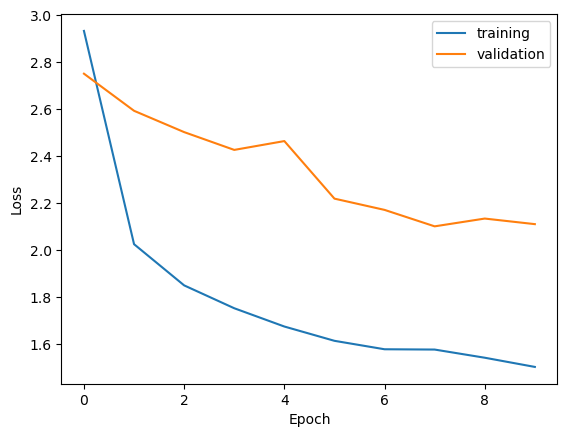

In [186]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

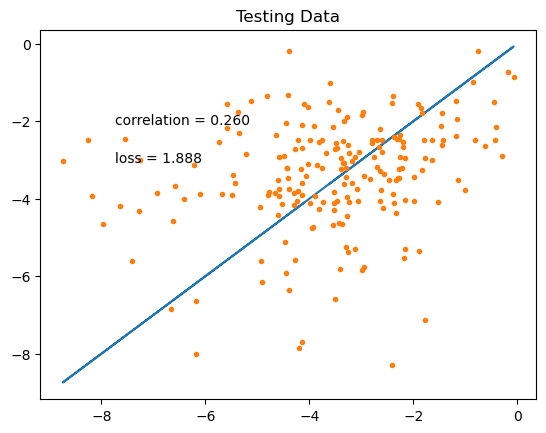

In [184]:
yhat = model.predict(test_data.batch(1), verbose=0)[:, 0]
test_y = [y for x, y in test_data]
plt.figure()
plt.plot(test_y, test_y, "-")
plt.plot(test_y, yhat, ".")
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()

Battaglia general equation: a generalization of GNNs.

We first aggregate the edge feature information:

$$
\vec{e}_k '= \phi^e (\vec{e}_k, \vec{v}_{rk},\vec{v}_{sk}, \vec{u})
$$

$\vec{e}_k$ is some feature on edge $k=\{ij\}$, $r,s$ stands for some feature indices, and $\vec{u}$ is some global graph features. 

After this, we aggregate this onto node $i$

$$
\bar{e}'_{i} = \rho^{e\rightarrow v}(E'_i)
$$

$E_i'$ is the aggregate function of all edges that comes through node $i$. Note that $\bar{e}$ is NOT $\vec{e}$—whoever came up with this notation is a bloody genius.

Then, we may update the node update

$$
\vec{v}_i' = \phi^v(\bar{e}'_{i}, \vec{i}, \vec{u})
$$


in our previous GCN, we simply have $\vec{e}_k = \vec{v}_{sk} W$, aggregate by taking average $\bar{e}'_{i} = \rho^{e\rightarrow v}(E'_i) = \frac{1}{|E_i'|} \sum E_i'$, before update the vertices accordingly $\vec{v}_i' = \phi^v(\bar{e}'_{i}, \vec{i}, \vec{u}) = \sigma(\bar{e}_i')$

If we want to update some graph vectors, we may also aggregate the edge and vertices across the whole graph, before taking the update on the graph feature vector. 


In [3]:
soldata

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.000000,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.000000,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.000000,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.000000,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.000000,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,I-84,tetracaine,InChI=1S/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9...,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,0.000000,1,G1,264.369,...,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548e+00,374.236893
9978,I-85,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,0.000000,1,G1,444.440,...,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922e+00,1148.584975
9979,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,...,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720e+00,251.049732
9980,I-93,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,0.000000,1,G1,454.611,...,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333e+00,938.203977


In [ ]:
gcnlayer = GCNLayer("relu")
# we insert a batch axis here
print(gcnlayer((nodes[np.newaxis, ...], adj_mat[np.newaxis, ...]))) #This is just a convoluted way to make this a batch of one

def swap_basis(node, adj_mat, permutation):
    temp1 = node.copy()
    temp2 = adj_mat.copy()
    temp1 = temp1[permutation]
    temp2[permutation, :] = temp2[[i for i in range(len(permutation))],:]
    temp2[:, permutation] = temp2[:, [i for i in range(len(permutation))]]
    return temp1, temp2

new_nodes, new_adj_mat = swap_basis(nodes, adj_mat, [1,0,3,4,5,2])
        
print(gcnlayer((new_nodes[np.newaxis, ...], new_adj_mat[np.newaxis, ...]))) #This seems covariant with permutation